In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import keras
import tensorflow as tf

Using TensorFlow backend.
/Users/noe/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
rcParams.update({'font.size': 16})

In [4]:
# Switch AUTORELOAD ON. Disable this when in production mode!
%load_ext autoreload
%autoreload 2

In [5]:
from deep_boltzmann.models import DoubleWell
from deep_boltzmann.networks.invertible import invnet
from deep_boltzmann.sampling import GaussianPriorMCMC
from deep_boltzmann.networks.plot import test_xz_projection
from deep_boltzmann.util import count_transitions
from deep_boltzmann.sampling.analysis import free_energy_bootstrap, mean_finite, std_finite

Conditional oscillator
---
Harmonic potential in R2 conditioned on mean

In [78]:
class Cond2DOscillator(object):
    
    def __init__(self, k=1.0):
        """ 2D oscillator with force constant k
        
        Energy function is (k/2) [(x-cx)^2 + (y-cy)^2]
        
        """
        self.k = k
        self.dim = 4
        
    def energy(self, x):
        return 0.5 * self.k * ((x[:, 0] - x[:, 2])**2 + (x[:, 1] - x[:, 3])**2)

    def energy_tf(self, x):
        return self.energy(x)

    def plot_energy(self, mean=None):
        if mean is None:
            mean = [0, 0]
        xmin = mean[0] - 5.0/self.k
        xmax = mean[0] + 5.0/self.k
        ymin = mean[1] - 5.0/self.k
        ymax = mean[1] + 5.0/self.k
        xgrid = np.linspace(xmin, xmax)
        ygrid = np.linspace(ymin, ymax)
        X, Y = np.meshgrid(xgrid, ygrid)
        crds = np.hstack([X.flatten()[:, None], Y.flatten()[:, None],
                          mean[0]*np.ones((X.size, 1)), mean[1]*np.ones((X.size, 1))])
        Z = self.energy(crds).reshape(X.shape)
        fig = plt.figure(figsize=(7.5, 6))
        plt.contourf(X, Y, Z, 50, cmap=plt.cm.jet)
        plt.colorbar()

In [58]:
class Static2DOscillator(object):
    
    def __init__(self, k=1.0):
        """ 2D oscillator with force constant k
        
        Energy function is (k/2) [(x-cx)^2 + (y-cy)^2]
        
        """
        self.k = k
        self.dim = 2
        
    def energy(self, x):
        return 0.5 * self.k * (x[:, 0]**2 + x[:, 1]**2)

    def energy_tf(self, x):
        return self.energy(x)

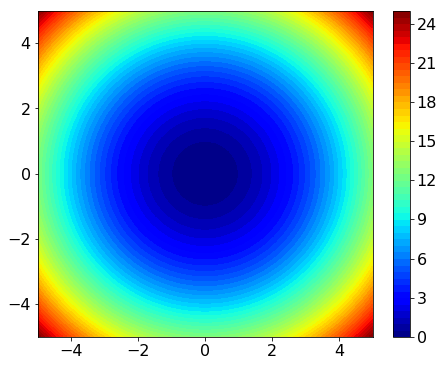

In [13]:
cond2dOscillator = Cond2DOscillator()
cond2dOscillator.plot_energy()

In [57]:
# simulation data
from deep_boltzmann.sampling import MetropolisGauss

In [61]:
nsteps = 100000
x0 = np.array([[0.0, 0.0]])

static_oscillator = Static2DOscillator()
sampler = MetropolisGauss(static_oscillator, x0, noise=0.1, stride=10)
sampler.run(nsteps)
traj_static = sampler.traj.copy()

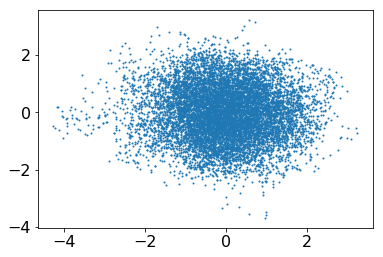

In [65]:
plt.plot(traj_static[:, 0], traj_static[:, 1], marker='.', markersize=2, linewidth=0)

In [68]:
# Generate drifting dataset for conditional estimation
mean_grid = np.linspace(-5, 5, traj_static.shape[0])
traj_drifting = traj_static + np.hstack([mean_grid[:, None], mean_grid[:, None]])

In [74]:
x = np.hstack([traj_drifting, mean_grid[:, None], mean_grid[:, None]])

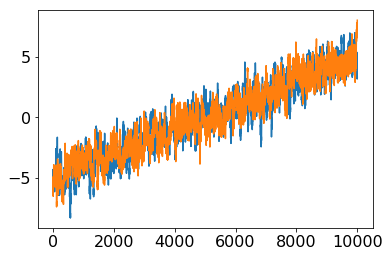

In [72]:
plt.plot(traj_drifting[:, 0])
plt.plot(traj_drifting[:, 1])

Learn
----

In [130]:
x_train = x[::2]
x_val = x[1::2]

In [134]:
from deep_boltzmann.networks import invnet

In [135]:
network = invnet(4, 2, 'R', energy_model=cond2dOscillator, 
                 nl_layers=2, nl_hidden=100, nl_activation='tanh', 
                 condition=(2, 2))

<R>


In [136]:
losses = network.train_flexible(x_train, xval=x_val, lr=0.0001)

Epoch 0/2000 loss 25.3504 23.7637 output_z_loss 13.0066 11.9947 concatenate_125_loss 12.3438 11.7690 
Epoch 1/2000 loss 24.4511 23.5926 output_z_loss 12.3369 11.9105 concatenate_125_loss 12.1143 11.6821 
Epoch 2/2000 loss 23.3317 24.9801 output_z_loss 11.7613 12.5756 concatenate_125_loss 11.5704 12.4045 
Epoch 3/2000 loss 24.5051 24.5113 output_z_loss 12.3924 12.1628 concatenate_125_loss 12.1127 12.3485 
Epoch 4/2000 loss 24.2181 23.0190 output_z_loss 12.1735 11.5332 concatenate_125_loss 12.0446 11.4858 
Epoch 5/2000 loss 22.8267 22.8211 output_z_loss 11.5092 11.3358 concatenate_125_loss 11.3175 11.4852 
Epoch 6/2000 loss 21.9358 23.8347 output_z_loss 10.9186 11.7363 concatenate_125_loss 11.0172 12.0984 
Epoch 7/2000 loss 23.6955 23.3126 output_z_loss 11.8160 11.5344 concatenate_125_loss 11.8795 11.7782 
Epoch 8/2000 loss 23.8719 23.4069 output_z_loss 11.9790 11.6607 concatenate_125_loss 11.8929 11.7463 
Epoch 9/2000 loss 22.4434 22.5640 output_z_loss 11.2816 11.1322 concatenate_125_lo

Epoch 82/2000 loss 14.9393 14.1307 output_z_loss 6.9192 6.7587 concatenate_125_loss 8.0201 7.3720 
Epoch 83/2000 loss 14.2084 14.5327 output_z_loss 6.6483 6.8070 concatenate_125_loss 7.5600 7.7257 
Epoch 84/2000 loss 14.2501 14.7718 output_z_loss 6.6070 6.8006 concatenate_125_loss 7.6431 7.9712 
Epoch 85/2000 loss 14.4999 15.2199 output_z_loss 6.7850 7.0860 concatenate_125_loss 7.7149 8.1339 
Epoch 86/2000 loss 15.0935 14.7907 output_z_loss 7.1588 6.9038 concatenate_125_loss 7.9347 7.8869 
Epoch 87/2000 loss 15.4248 14.2248 output_z_loss 7.3477 6.6763 concatenate_125_loss 8.0771 7.5485 
Epoch 88/2000 loss 14.4912 13.7651 output_z_loss 6.7144 6.6252 concatenate_125_loss 7.7768 7.1399 
Epoch 89/2000 loss 14.1854 13.8923 output_z_loss 6.4987 6.4228 concatenate_125_loss 7.6867 7.4695 
Epoch 90/2000 loss 13.1746 13.5344 output_z_loss 6.1732 6.3093 concatenate_125_loss 7.0014 7.2251 
Epoch 91/2000 loss 13.5382 14.1189 output_z_loss 6.2975 6.4801 concatenate_125_loss 7.2407 7.6387 
Epoch 92/2

Epoch 165/2000 loss 8.5488 8.3254 output_z_loss 3.7181 3.6265 concatenate_125_loss 4.8307 4.6989 
Epoch 166/2000 loss 8.0177 8.5647 output_z_loss 3.5131 3.7908 concatenate_125_loss 4.5046 4.7739 
Epoch 167/2000 loss 7.9444 7.9123 output_z_loss 3.5436 3.4549 concatenate_125_loss 4.4008 4.4575 
Epoch 168/2000 loss 8.2969 7.8441 output_z_loss 3.5748 3.4783 concatenate_125_loss 4.7221 4.3658 
Epoch 169/2000 loss 7.7228 7.7764 output_z_loss 3.4128 3.3242 concatenate_125_loss 4.3100 4.4522 
Epoch 170/2000 loss 8.0540 7.6959 output_z_loss 3.5643 3.4148 concatenate_125_loss 4.4897 4.2811 
Epoch 171/2000 loss 8.1286 7.9412 output_z_loss 3.5148 3.5203 concatenate_125_loss 4.6138 4.4209 
Epoch 172/2000 loss 7.8433 7.6711 output_z_loss 3.4386 3.3507 concatenate_125_loss 4.4046 4.3205 
Epoch 173/2000 loss 7.6307 7.9531 output_z_loss 3.4056 3.5074 concatenate_125_loss 4.2251 4.4457 
Epoch 174/2000 loss 7.8868 7.7070 output_z_loss 3.3756 3.3035 concatenate_125_loss 4.5112 4.4035 
Epoch 175/2000 loss 

Epoch 249/2000 loss 4.6753 4.6632 output_z_loss 2.0084 2.1604 concatenate_125_loss 2.6669 2.5028 
Epoch 250/2000 loss 4.8526 4.7398 output_z_loss 2.1376 2.0942 concatenate_125_loss 2.7150 2.6455 
Epoch 251/2000 loss 4.7784 4.6799 output_z_loss 2.1039 2.0888 concatenate_125_loss 2.6745 2.5911 
Epoch 252/2000 loss 4.5737 4.4585 output_z_loss 1.9773 1.9873 concatenate_125_loss 2.5964 2.4712 
Epoch 253/2000 loss 4.5777 4.6076 output_z_loss 2.0407 1.9899 concatenate_125_loss 2.5370 2.6178 
Epoch 254/2000 loss 4.6086 4.6510 output_z_loss 2.0304 2.0237 concatenate_125_loss 2.5782 2.6274 
Epoch 255/2000 loss 4.6280 4.7062 output_z_loss 2.0935 2.1443 concatenate_125_loss 2.5345 2.5619 
Epoch 256/2000 loss 4.5205 4.6559 output_z_loss 2.0067 1.9876 concatenate_125_loss 2.5138 2.6684 
Epoch 257/2000 loss 4.5374 4.5448 output_z_loss 1.9028 2.0498 concatenate_125_loss 2.6347 2.4950 
Epoch 258/2000 loss 4.7004 4.4492 output_z_loss 2.0605 1.9955 concatenate_125_loss 2.6399 2.4537 
Epoch 259/2000 loss 

Epoch 333/2000 loss 3.3567 3.4562 output_z_loss 1.5641 1.6579 concatenate_125_loss 1.7926 1.7983 
Epoch 334/2000 loss 3.6072 3.4310 output_z_loss 1.6092 1.5307 concatenate_125_loss 1.9981 1.9004 
Epoch 335/2000 loss 3.4051 3.3365 output_z_loss 1.5759 1.5209 concatenate_125_loss 1.8292 1.8156 
Epoch 336/2000 loss 3.5078 3.3148 output_z_loss 1.5683 1.4856 concatenate_125_loss 1.9395 1.8292 
Epoch 337/2000 loss 3.4198 3.3258 output_z_loss 1.4984 1.5573 concatenate_125_loss 1.9214 1.7685 
Epoch 338/2000 loss 3.4170 3.2049 output_z_loss 1.5483 1.4459 concatenate_125_loss 1.8687 1.7591 
Epoch 339/2000 loss 3.2481 3.3375 output_z_loss 1.4772 1.5327 concatenate_125_loss 1.7709 1.8047 
Epoch 340/2000 loss 3.3802 3.3503 output_z_loss 1.6374 1.5325 concatenate_125_loss 1.7428 1.8179 
Epoch 341/2000 loss 3.5111 3.2657 output_z_loss 1.5816 1.5432 concatenate_125_loss 1.9295 1.7225 
Epoch 342/2000 loss 3.2117 3.3206 output_z_loss 1.4918 1.4538 concatenate_125_loss 1.7199 1.8669 
Epoch 343/2000 loss 

Epoch 417/2000 loss 2.7774 2.6363 output_z_loss 1.3044 1.2607 concatenate_125_loss 1.4730 1.3757 
Epoch 418/2000 loss 2.8383 2.8054 output_z_loss 1.2849 1.2717 concatenate_125_loss 1.5534 1.5337 
Epoch 419/2000 loss 2.7706 2.6681 output_z_loss 1.3643 1.2624 concatenate_125_loss 1.4064 1.4057 
Epoch 420/2000 loss 2.7272 2.7954 output_z_loss 1.2711 1.2771 concatenate_125_loss 1.4562 1.5182 
Epoch 421/2000 loss 2.8917 2.8492 output_z_loss 1.3765 1.2979 concatenate_125_loss 1.5153 1.5513 
Epoch 422/2000 loss 2.8082 2.7058 output_z_loss 1.3519 1.2639 concatenate_125_loss 1.4563 1.4419 
Epoch 423/2000 loss 2.6495 2.7400 output_z_loss 1.2906 1.3278 concatenate_125_loss 1.3589 1.4122 
Epoch 424/2000 loss 2.6959 2.7307 output_z_loss 1.3531 1.2558 concatenate_125_loss 1.3428 1.4749 
Epoch 425/2000 loss 2.7463 2.6764 output_z_loss 1.3037 1.2598 concatenate_125_loss 1.4427 1.4166 
Epoch 426/2000 loss 2.7514 2.7310 output_z_loss 1.2686 1.3328 concatenate_125_loss 1.4828 1.3982 
Epoch 427/2000 loss 

Epoch 501/2000 loss 2.5486 2.5058 output_z_loss 1.1857 1.1673 concatenate_125_loss 1.3629 1.3385 
Epoch 502/2000 loss 2.4362 2.4814 output_z_loss 1.1718 1.2602 concatenate_125_loss 1.2644 1.2212 
Epoch 503/2000 loss 2.5210 2.5256 output_z_loss 1.2544 1.2266 concatenate_125_loss 1.2666 1.2990 
Epoch 504/2000 loss 2.5576 2.5632 output_z_loss 1.2014 1.2208 concatenate_125_loss 1.3562 1.3423 
Epoch 505/2000 loss 2.5026 2.4988 output_z_loss 1.2534 1.2245 concatenate_125_loss 1.2492 1.2743 
Epoch 506/2000 loss 2.4971 2.4562 output_z_loss 1.2741 1.1946 concatenate_125_loss 1.2230 1.2616 
Epoch 507/2000 loss 2.4060 2.4975 output_z_loss 1.1444 1.1961 concatenate_125_loss 1.2616 1.3014 
Epoch 508/2000 loss 2.6279 2.6859 output_z_loss 1.3210 1.2676 concatenate_125_loss 1.3069 1.4183 
Epoch 509/2000 loss 2.4665 2.5227 output_z_loss 1.1697 1.1919 concatenate_125_loss 1.2968 1.3308 
Epoch 510/2000 loss 2.4012 2.4828 output_z_loss 1.1965 1.2035 concatenate_125_loss 1.2048 1.2793 
Epoch 511/2000 loss 

Epoch 585/2000 loss 2.3793 2.4023 output_z_loss 1.1358 1.1484 concatenate_125_loss 1.2435 1.2539 
Epoch 586/2000 loss 2.2900 2.2579 output_z_loss 1.1623 1.1014 concatenate_125_loss 1.1277 1.1565 
Epoch 587/2000 loss 2.3831 2.3688 output_z_loss 1.1530 1.1705 concatenate_125_loss 1.2301 1.1984 
Epoch 588/2000 loss 2.3877 2.3526 output_z_loss 1.2040 1.1308 concatenate_125_loss 1.1837 1.2218 
Epoch 589/2000 loss 2.3086 2.3919 output_z_loss 1.1678 1.1441 concatenate_125_loss 1.1408 1.2478 
Epoch 590/2000 loss 2.4660 2.3357 output_z_loss 1.1806 1.0972 concatenate_125_loss 1.2854 1.2385 
Epoch 591/2000 loss 2.3717 2.3790 output_z_loss 1.1736 1.1654 concatenate_125_loss 1.1981 1.2136 
Epoch 592/2000 loss 2.3299 2.3671 output_z_loss 1.2121 1.1074 concatenate_125_loss 1.1177 1.2597 
Epoch 593/2000 loss 2.3806 2.3248 output_z_loss 1.1658 1.1373 concatenate_125_loss 1.2148 1.1875 
Epoch 594/2000 loss 2.3726 2.3406 output_z_loss 1.1710 1.1344 concatenate_125_loss 1.2016 1.2062 
Epoch 595/2000 loss 

Epoch 669/2000 loss 2.2978 2.3814 output_z_loss 1.1484 1.1781 concatenate_125_loss 1.1494 1.2032 
Epoch 670/2000 loss 2.2999 2.3238 output_z_loss 1.1608 1.1474 concatenate_125_loss 1.1391 1.1764 
Epoch 671/2000 loss 2.2481 2.4663 output_z_loss 1.1179 1.1703 concatenate_125_loss 1.1302 1.2959 
Epoch 672/2000 loss 2.3345 2.3446 output_z_loss 1.1371 1.1171 concatenate_125_loss 1.1974 1.2275 
Epoch 673/2000 loss 2.2664 2.3525 output_z_loss 1.1100 1.1094 concatenate_125_loss 1.1564 1.2431 
Epoch 674/2000 loss 2.2910 2.2872 output_z_loss 1.1156 1.1019 concatenate_125_loss 1.1754 1.1854 
Epoch 675/2000 loss 2.2586 2.2670 output_z_loss 1.1014 1.1312 concatenate_125_loss 1.1573 1.1358 
Epoch 676/2000 loss 2.2823 2.2385 output_z_loss 1.1207 1.1193 concatenate_125_loss 1.1616 1.1192 
Epoch 677/2000 loss 2.3494 2.3933 output_z_loss 1.1308 1.1701 concatenate_125_loss 1.2186 1.2232 
Epoch 678/2000 loss 2.2611 2.2513 output_z_loss 1.1036 1.1030 concatenate_125_loss 1.1574 1.1483 
Epoch 679/2000 loss 

Epoch 753/2000 loss 2.2091 2.2243 output_z_loss 1.0746 1.1054 concatenate_125_loss 1.1345 1.1189 
Epoch 754/2000 loss 2.2627 2.2603 output_z_loss 1.1467 1.1306 concatenate_125_loss 1.1159 1.1298 
Epoch 755/2000 loss 2.3231 2.2313 output_z_loss 1.1550 1.1100 concatenate_125_loss 1.1681 1.1213 
Epoch 756/2000 loss 2.2673 2.2670 output_z_loss 1.1166 1.0720 concatenate_125_loss 1.1507 1.1950 
Epoch 757/2000 loss 2.2233 2.3683 output_z_loss 1.1320 1.1360 concatenate_125_loss 1.0913 1.2323 
Epoch 758/2000 loss 2.2754 2.3045 output_z_loss 1.1162 1.1423 concatenate_125_loss 1.1592 1.1622 
Epoch 759/2000 loss 2.3249 2.3069 output_z_loss 1.1628 1.1258 concatenate_125_loss 1.1621 1.1810 
Epoch 760/2000 loss 2.3643 2.2336 output_z_loss 1.1579 1.1052 concatenate_125_loss 1.2064 1.1284 
Epoch 761/2000 loss 2.3595 2.2099 output_z_loss 1.1591 1.0713 concatenate_125_loss 1.2004 1.1385 
Epoch 762/2000 loss 2.3438 2.2834 output_z_loss 1.1545 1.1576 concatenate_125_loss 1.1893 1.1258 
Epoch 763/2000 loss 

Epoch 837/2000 loss 2.3017 2.1388 output_z_loss 1.1009 1.0626 concatenate_125_loss 1.2008 1.0762 
Epoch 838/2000 loss 2.2692 2.2635 output_z_loss 1.1495 1.1109 concatenate_125_loss 1.1197 1.1527 
Epoch 839/2000 loss 2.1855 2.1828 output_z_loss 1.0972 1.0388 concatenate_125_loss 1.0883 1.1440 
Epoch 840/2000 loss 2.1293 2.2173 output_z_loss 1.0693 1.0797 concatenate_125_loss 1.0600 1.1376 
Epoch 841/2000 loss 2.2007 2.2748 output_z_loss 1.0741 1.1099 concatenate_125_loss 1.1265 1.1648 
Epoch 842/2000 loss 2.2955 2.2230 output_z_loss 1.0821 1.0822 concatenate_125_loss 1.2133 1.1408 
Epoch 843/2000 loss 2.2782 2.3052 output_z_loss 1.1057 1.1409 concatenate_125_loss 1.1725 1.1643 
Epoch 844/2000 loss 2.2701 2.3235 output_z_loss 1.0735 1.1080 concatenate_125_loss 1.1967 1.2155 
Epoch 845/2000 loss 2.3334 2.2807 output_z_loss 1.1449 1.1005 concatenate_125_loss 1.1884 1.1802 
Epoch 846/2000 loss 2.2080 2.3825 output_z_loss 1.1117 1.1922 concatenate_125_loss 1.0963 1.1903 
Epoch 847/2000 loss 

Epoch 921/2000 loss 2.2372 2.1476 output_z_loss 1.0992 1.0651 concatenate_125_loss 1.1380 1.0826 
Epoch 922/2000 loss 2.3036 2.1831 output_z_loss 1.1267 1.0643 concatenate_125_loss 1.1769 1.1188 
Epoch 923/2000 loss 2.1283 2.1885 output_z_loss 1.0732 1.0912 concatenate_125_loss 1.0552 1.0973 
Epoch 924/2000 loss 2.2133 2.2056 output_z_loss 1.0992 1.0979 concatenate_125_loss 1.1141 1.1077 
Epoch 925/2000 loss 2.1517 2.1896 output_z_loss 1.0125 1.0783 concatenate_125_loss 1.1392 1.1114 
Epoch 926/2000 loss 2.1850 2.1729 output_z_loss 1.0959 1.1045 concatenate_125_loss 1.0891 1.0684 
Epoch 927/2000 loss 2.2470 2.2558 output_z_loss 1.1060 1.1307 concatenate_125_loss 1.1410 1.1250 
Epoch 928/2000 loss 2.2725 2.1420 output_z_loss 1.1202 1.0409 concatenate_125_loss 1.1523 1.1011 
Epoch 929/2000 loss 2.2000 2.1722 output_z_loss 1.0869 1.1138 concatenate_125_loss 1.1131 1.0584 
Epoch 930/2000 loss 2.2229 2.2616 output_z_loss 1.1196 1.1106 concatenate_125_loss 1.1033 1.1510 
Epoch 931/2000 loss 

Epoch 1005/2000 loss 2.1927 2.1479 output_z_loss 1.0530 1.0725 concatenate_125_loss 1.1398 1.0754 
Epoch 1006/2000 loss 2.1980 2.2264 output_z_loss 1.0659 1.0861 concatenate_125_loss 1.1321 1.1403 
Epoch 1007/2000 loss 2.1593 2.1773 output_z_loss 1.0886 1.1238 concatenate_125_loss 1.0708 1.0535 
Epoch 1008/2000 loss 2.1489 2.2117 output_z_loss 1.1194 1.0732 concatenate_125_loss 1.0295 1.1386 
Epoch 1009/2000 loss 2.1451 2.1591 output_z_loss 1.0806 1.0851 concatenate_125_loss 1.0646 1.0739 
Epoch 1010/2000 loss 2.2181 2.2235 output_z_loss 1.0640 1.0699 concatenate_125_loss 1.1542 1.1536 
Epoch 1011/2000 loss 2.2582 2.1717 output_z_loss 1.1071 1.0737 concatenate_125_loss 1.1511 1.0980 
Epoch 1012/2000 loss 2.2111 2.2384 output_z_loss 1.1174 1.1144 concatenate_125_loss 1.0937 1.1240 
Epoch 1013/2000 loss 2.0967 2.1411 output_z_loss 1.0357 1.0622 concatenate_125_loss 1.0610 1.0789 
Epoch 1014/2000 loss 2.2268 2.1505 output_z_loss 1.1337 1.0901 concatenate_125_loss 1.0932 1.0604 
Epoch 1015

Epoch 1088/2000 loss 2.1437 2.1165 output_z_loss 1.0602 1.0379 concatenate_125_loss 1.0835 1.0787 
Epoch 1089/2000 loss 2.1146 2.1793 output_z_loss 1.0468 1.1114 concatenate_125_loss 1.0677 1.0679 
Epoch 1090/2000 loss 2.1189 2.1991 output_z_loss 1.0771 1.0880 concatenate_125_loss 1.0418 1.1112 
Epoch 1091/2000 loss 2.1451 2.2542 output_z_loss 1.0200 1.1149 concatenate_125_loss 1.1251 1.1393 
Epoch 1092/2000 loss 2.1643 2.1756 output_z_loss 1.0672 1.0636 concatenate_125_loss 1.0971 1.1119 
Epoch 1093/2000 loss 2.1800 2.1636 output_z_loss 1.0553 1.0574 concatenate_125_loss 1.1247 1.1062 
Epoch 1094/2000 loss 2.1222 2.1463 output_z_loss 1.0726 1.0667 concatenate_125_loss 1.0496 1.0796 
Epoch 1095/2000 loss 2.1277 2.2029 output_z_loss 1.0791 1.0971 concatenate_125_loss 1.0485 1.1057 
Epoch 1096/2000 loss 2.0814 2.2458 output_z_loss 1.0156 1.0926 concatenate_125_loss 1.0658 1.1532 
Epoch 1097/2000 loss 2.2234 2.2085 output_z_loss 1.0886 1.0653 concatenate_125_loss 1.1348 1.1432 
Epoch 1098

Epoch 1171/2000 loss 2.1546 2.1544 output_z_loss 1.0817 1.0915 concatenate_125_loss 1.0730 1.0629 
Epoch 1172/2000 loss 2.1198 2.1450 output_z_loss 1.0583 1.1310 concatenate_125_loss 1.0616 1.0140 
Epoch 1173/2000 loss 2.1470 2.1919 output_z_loss 1.0495 1.0629 concatenate_125_loss 1.0975 1.1291 
Epoch 1174/2000 loss 2.2292 2.1410 output_z_loss 1.1039 1.0438 concatenate_125_loss 1.1253 1.0972 
Epoch 1175/2000 loss 2.1703 2.0745 output_z_loss 1.0853 1.0279 concatenate_125_loss 1.0850 1.0465 
Epoch 1176/2000 loss 2.1273 2.1721 output_z_loss 1.0471 1.0634 concatenate_125_loss 1.0802 1.1087 
Epoch 1177/2000 loss 2.1543 2.1130 output_z_loss 1.0725 1.0664 concatenate_125_loss 1.0818 1.0465 
Epoch 1178/2000 loss 2.2490 2.1092 output_z_loss 1.1073 1.0250 concatenate_125_loss 1.1417 1.0843 
Epoch 1179/2000 loss 2.1570 2.0663 output_z_loss 1.0974 1.0669 concatenate_125_loss 1.0596 0.9994 
Epoch 1180/2000 loss 2.2008 2.1113 output_z_loss 1.0968 1.0979 concatenate_125_loss 1.1040 1.0134 
Epoch 1181

Epoch 1254/2000 loss 2.1722 2.2002 output_z_loss 1.0479 1.1052 concatenate_125_loss 1.1243 1.0951 
Epoch 1255/2000 loss 2.1774 2.1849 output_z_loss 1.0864 1.0590 concatenate_125_loss 1.0910 1.1260 
Epoch 1256/2000 loss 2.1454 2.1151 output_z_loss 1.0459 1.0187 concatenate_125_loss 1.0995 1.0964 
Epoch 1257/2000 loss 2.0777 2.1793 output_z_loss 1.0307 1.0702 concatenate_125_loss 1.0470 1.1092 
Epoch 1258/2000 loss 2.1923 2.0699 output_z_loss 1.0810 1.0550 concatenate_125_loss 1.1113 1.0148 
Epoch 1259/2000 loss 2.1437 2.1510 output_z_loss 1.0222 1.1048 concatenate_125_loss 1.1215 1.0462 
Epoch 1260/2000 loss 2.1862 2.2270 output_z_loss 1.0773 1.1285 concatenate_125_loss 1.1089 1.0985 
Epoch 1261/2000 loss 2.1281 2.0730 output_z_loss 1.0757 0.9859 concatenate_125_loss 1.0524 1.0871 
Epoch 1262/2000 loss 2.1238 2.2684 output_z_loss 1.0336 1.0655 concatenate_125_loss 1.0902 1.2028 
Epoch 1263/2000 loss 2.1055 2.0779 output_z_loss 1.0762 1.0398 concatenate_125_loss 1.0292 1.0381 
Epoch 1264

Epoch 1337/2000 loss 1.9723 2.1690 output_z_loss 0.9789 1.0607 concatenate_125_loss 0.9934 1.1083 
Epoch 1338/2000 loss 2.1160 2.0619 output_z_loss 1.0330 1.0228 concatenate_125_loss 1.0830 1.0390 
Epoch 1339/2000 loss 2.2384 2.0618 output_z_loss 1.0928 1.0350 concatenate_125_loss 1.1456 1.0268 
Epoch 1340/2000 loss 2.1508 2.1315 output_z_loss 1.1183 1.0722 concatenate_125_loss 1.0324 1.0593 
Epoch 1341/2000 loss 2.0753 2.0988 output_z_loss 1.0289 1.0340 concatenate_125_loss 1.0464 1.0648 
Epoch 1342/2000 loss 2.0536 2.0458 output_z_loss 1.0689 0.9885 concatenate_125_loss 0.9847 1.0573 
Epoch 1343/2000 loss 2.0610 2.1160 output_z_loss 1.0538 1.0454 concatenate_125_loss 1.0071 1.0706 
Epoch 1344/2000 loss 2.1465 2.1157 output_z_loss 1.0775 1.0140 concatenate_125_loss 1.0690 1.1018 
Epoch 1345/2000 loss 2.1616 2.0768 output_z_loss 1.0792 1.0240 concatenate_125_loss 1.0824 1.0528 
Epoch 1346/2000 loss 2.2065 2.1355 output_z_loss 1.0881 1.0197 concatenate_125_loss 1.1184 1.1158 
Epoch 1347

Epoch 1420/2000 loss 2.1732 2.0552 output_z_loss 1.0609 1.0302 concatenate_125_loss 1.1123 1.0249 
Epoch 1421/2000 loss 2.1148 2.0541 output_z_loss 1.0376 0.9892 concatenate_125_loss 1.0772 1.0649 
Epoch 1422/2000 loss 2.1040 2.0787 output_z_loss 1.0519 1.0089 concatenate_125_loss 1.0521 1.0698 
Epoch 1423/2000 loss 2.1105 2.1764 output_z_loss 1.0260 1.0480 concatenate_125_loss 1.0844 1.1284 
Epoch 1424/2000 loss 2.0420 2.0951 output_z_loss 1.0024 1.0070 concatenate_125_loss 1.0397 1.0881 
Epoch 1425/2000 loss 2.0511 2.1818 output_z_loss 1.0218 1.0896 concatenate_125_loss 1.0293 1.0921 
Epoch 1426/2000 loss 2.1099 2.1179 output_z_loss 1.0194 1.0619 concatenate_125_loss 1.0905 1.0560 
Epoch 1427/2000 loss 2.0967 2.1005 output_z_loss 1.0353 1.0370 concatenate_125_loss 1.0614 1.0635 
Epoch 1428/2000 loss 2.2219 2.0959 output_z_loss 1.0760 1.0453 concatenate_125_loss 1.1459 1.0506 
Epoch 1429/2000 loss 2.1836 2.1505 output_z_loss 1.1178 1.0366 concatenate_125_loss 1.0658 1.1139 
Epoch 1430

Epoch 1503/2000 loss 2.0829 2.1222 output_z_loss 1.0427 1.0433 concatenate_125_loss 1.0402 1.0789 
Epoch 1504/2000 loss 2.1762 2.1477 output_z_loss 1.0592 1.0564 concatenate_125_loss 1.1169 1.0913 
Epoch 1505/2000 loss 1.9895 2.1591 output_z_loss 1.0123 1.0706 concatenate_125_loss 0.9772 1.0885 
Epoch 1506/2000 loss 2.0941 2.0852 output_z_loss 1.0429 1.0456 concatenate_125_loss 1.0513 1.0396 
Epoch 1507/2000 loss 2.1530 2.1463 output_z_loss 1.0590 1.0986 concatenate_125_loss 1.0940 1.0477 
Epoch 1508/2000 loss 2.0676 2.0966 output_z_loss 1.0543 1.0468 concatenate_125_loss 1.0133 1.0499 
Epoch 1509/2000 loss 2.0575 2.1042 output_z_loss 1.0346 1.0501 concatenate_125_loss 1.0229 1.0541 
Epoch 1510/2000 loss 2.0211 2.0506 output_z_loss 1.0055 0.9999 concatenate_125_loss 1.0156 1.0506 
Epoch 1511/2000 loss 2.0274 2.0369 output_z_loss 1.0092 1.0175 concatenate_125_loss 1.0183 1.0193 
Epoch 1512/2000 loss 2.0758 2.0887 output_z_loss 1.0515 0.9988 concatenate_125_loss 1.0243 1.0899 
Epoch 1513

Epoch 1586/2000 loss 2.1317 2.1655 output_z_loss 1.0026 1.0857 concatenate_125_loss 1.1292 1.0799 
Epoch 1587/2000 loss 2.1246 2.0504 output_z_loss 1.0274 1.0214 concatenate_125_loss 1.0972 1.0289 
Epoch 1588/2000 loss 2.0318 2.0932 output_z_loss 1.0019 1.0398 concatenate_125_loss 1.0299 1.0534 
Epoch 1589/2000 loss 2.1037 2.0791 output_z_loss 1.0214 1.0442 concatenate_125_loss 1.0824 1.0349 
Epoch 1590/2000 loss 2.0646 2.0787 output_z_loss 1.0843 1.0009 concatenate_125_loss 0.9803 1.0778 
Epoch 1591/2000 loss 2.0425 2.0358 output_z_loss 1.0427 0.9829 concatenate_125_loss 0.9997 1.0529 
Epoch 1592/2000 loss 2.1383 2.0668 output_z_loss 1.0409 0.9479 concatenate_125_loss 1.0974 1.1189 
Epoch 1593/2000 loss 1.9840 2.1160 output_z_loss 1.0165 1.0769 concatenate_125_loss 0.9675 1.0391 
Epoch 1594/2000 loss 2.0820 2.1748 output_z_loss 1.0430 1.0740 concatenate_125_loss 1.0390 1.1007 
Epoch 1595/2000 loss 2.0912 2.0565 output_z_loss 1.0118 1.0422 concatenate_125_loss 1.0794 1.0144 
Epoch 1596

Epoch 1669/2000 loss 2.0259 2.0666 output_z_loss 1.0625 1.0069 concatenate_125_loss 0.9635 1.0597 
Epoch 1670/2000 loss 2.0866 2.0538 output_z_loss 1.0296 1.0643 concatenate_125_loss 1.0570 0.9895 
Epoch 1671/2000 loss 2.1169 2.0253 output_z_loss 1.0697 1.0325 concatenate_125_loss 1.0472 0.9929 
Epoch 1672/2000 loss 2.0673 2.0875 output_z_loss 1.0542 1.0348 concatenate_125_loss 1.0132 1.0526 
Epoch 1673/2000 loss 1.9616 2.1425 output_z_loss 0.9959 1.0599 concatenate_125_loss 0.9657 1.0826 
Epoch 1674/2000 loss 1.9599 2.0854 output_z_loss 0.9446 1.0335 concatenate_125_loss 1.0154 1.0519 
Epoch 1675/2000 loss 2.0729 2.0878 output_z_loss 1.0281 1.0539 concatenate_125_loss 1.0448 1.0339 
Epoch 1676/2000 loss 2.1323 2.0411 output_z_loss 1.0559 0.9979 concatenate_125_loss 1.0764 1.0431 
Epoch 1677/2000 loss 2.0190 2.0370 output_z_loss 0.9806 1.0250 concatenate_125_loss 1.0384 1.0120 
Epoch 1678/2000 loss 2.0969 2.1875 output_z_loss 1.0191 1.0593 concatenate_125_loss 1.0778 1.1282 
Epoch 1679

Epoch 1752/2000 loss 2.1218 2.1223 output_z_loss 1.0550 1.0545 concatenate_125_loss 1.0669 1.0678 
Epoch 1753/2000 loss 2.1009 2.1447 output_z_loss 1.0340 1.0531 concatenate_125_loss 1.0670 1.0916 
Epoch 1754/2000 loss 2.0209 2.0021 output_z_loss 0.9850 0.9765 concatenate_125_loss 1.0360 1.0256 
Epoch 1755/2000 loss 2.0106 2.0814 output_z_loss 0.9945 1.0180 concatenate_125_loss 1.0161 1.0634 
Epoch 1756/2000 loss 2.0575 2.0458 output_z_loss 1.0424 1.0246 concatenate_125_loss 1.0151 1.0212 
Epoch 1757/2000 loss 2.0332 2.1031 output_z_loss 0.9969 1.0594 concatenate_125_loss 1.0363 1.0437 
Epoch 1758/2000 loss 2.0586 2.0775 output_z_loss 1.0195 1.0507 concatenate_125_loss 1.0391 1.0268 
Epoch 1759/2000 loss 2.1534 2.0695 output_z_loss 1.0847 0.9867 concatenate_125_loss 1.0687 1.0828 
Epoch 1760/2000 loss 2.0343 1.9721 output_z_loss 0.9617 1.0090 concatenate_125_loss 1.0726 0.9631 
Epoch 1761/2000 loss 2.0897 2.1174 output_z_loss 1.0303 1.0674 concatenate_125_loss 1.0593 1.0500 
Epoch 1762

Epoch 1835/2000 loss 1.9715 2.0235 output_z_loss 0.9773 0.9842 concatenate_125_loss 0.9942 1.0393 
Epoch 1836/2000 loss 2.0647 2.0306 output_z_loss 1.0139 1.0178 concatenate_125_loss 1.0508 1.0128 
Epoch 1837/2000 loss 2.0842 2.0445 output_z_loss 1.0027 1.0078 concatenate_125_loss 1.0815 1.0366 
Epoch 1838/2000 loss 2.0721 2.0585 output_z_loss 1.0419 0.9926 concatenate_125_loss 1.0301 1.0659 
Epoch 1839/2000 loss 2.0668 2.0479 output_z_loss 0.9953 1.0309 concatenate_125_loss 1.0715 1.0169 
Epoch 1840/2000 loss 2.0097 2.0782 output_z_loss 0.9562 1.0340 concatenate_125_loss 1.0534 1.0441 
Epoch 1841/2000 loss 2.0562 2.0625 output_z_loss 1.0235 1.0457 concatenate_125_loss 1.0328 1.0168 
Epoch 1842/2000 loss 2.0092 2.0300 output_z_loss 0.9954 1.0022 concatenate_125_loss 1.0138 1.0277 
Epoch 1843/2000 loss 2.0922 2.1187 output_z_loss 1.0503 1.0550 concatenate_125_loss 1.0419 1.0637 
Epoch 1844/2000 loss 2.0467 2.0267 output_z_loss 1.0051 0.9851 concatenate_125_loss 1.0417 1.0416 
Epoch 1845

Epoch 1918/2000 loss 2.1093 2.0322 output_z_loss 1.0137 1.0037 concatenate_125_loss 1.0956 1.0285 
Epoch 1919/2000 loss 2.0468 1.9911 output_z_loss 1.0277 0.9640 concatenate_125_loss 1.0191 1.0272 
Epoch 1920/2000 loss 2.0393 2.0777 output_z_loss 1.0455 1.0640 concatenate_125_loss 0.9938 1.0137 
Epoch 1921/2000 loss 1.9829 2.0315 output_z_loss 0.9720 0.9822 concatenate_125_loss 1.0109 1.0493 
Epoch 1922/2000 loss 2.0474 2.0340 output_z_loss 1.0350 0.9984 concatenate_125_loss 1.0124 1.0356 
Epoch 1923/2000 loss 2.0497 1.9923 output_z_loss 1.0164 1.0008 concatenate_125_loss 1.0333 0.9915 
Epoch 1924/2000 loss 2.0647 2.0250 output_z_loss 1.0224 1.0354 concatenate_125_loss 1.0423 0.9895 
Epoch 1925/2000 loss 2.0073 2.0579 output_z_loss 1.0330 1.0296 concatenate_125_loss 0.9743 1.0283 
Epoch 1926/2000 loss 2.0864 2.0666 output_z_loss 1.0562 1.0412 concatenate_125_loss 1.0303 1.0253 
Epoch 1927/2000 loss 2.0779 1.9925 output_z_loss 1.0241 0.9855 concatenate_125_loss 1.0539 1.0070 
Epoch 1928

[]

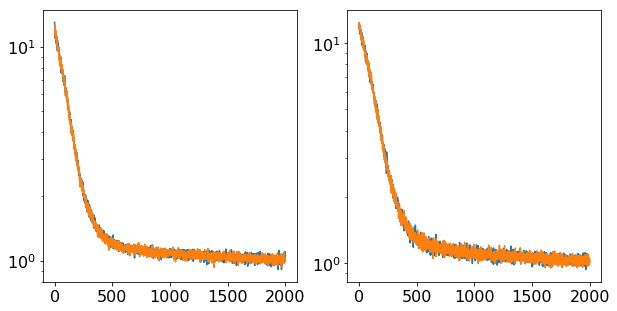

In [139]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(losses[1][:, 1])
axes[0].plot(losses[2][:, 1])
axes[0].semilogy()
axes[1].plot(losses[1][:, 2])
axes[1].plot(losses[2][:, 2])
axes[1].semilogy()

In [156]:
# test if conditional prediction makes sense
probe_mean = 4.0
xprobe = np.tile([0, 0, probe_mean, probe_mean], 1000).reshape((1000, 4))
_, xsample, _, _, _ = network.sample(nsample=1000, x=xprobe)

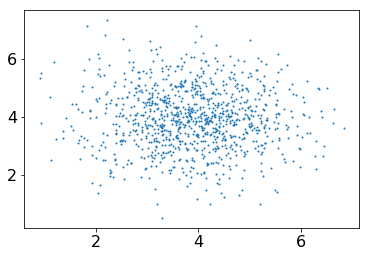

In [157]:
plt.plot(xsample[:, 0], xsample[:, 1], marker='.', markersize=2, linewidth=0)

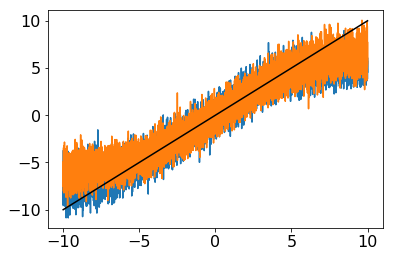

In [163]:
probe_means = np.linspace(-10, 10, 10000)
xprobe = np.hstack([np.zeros((10000, 2)), probe_means[:, None], probe_means[:, None]])
_, xsample, _, _, _ = network.sample(nsample=10000, x=xprobe)
plt.plot(xsample[:, 2], xsample[:, 0])
plt.plot(xsample[:, 3], xsample[:, 1])
plt.plot(probe_means, probe_means, color='black')

Repulsive Particles in 1D
-----

In [263]:
from deep_boltzmann.util import distance_matrix_squared

In [422]:
class RepulsiveParticles1D(object):
    
    def __init__(self, n=10, rm=0.1, k=10.0):
        """ Oscillators on periodic range [0, 1] with force constant k
        
        Energy of each oscillator b with neighbors a, c is (k/2) [(xb-xa-d)^2 + (xc-xb-d)^2]
        where d=1/n and minimum distances across periodic boundary conditions are applied.
        
        """
        self.n = n
        self.rm = rm
        self.k = k
        self.dim = n

        self.mask_matrix = np.ones((self.n+2, self.n+2), dtype=np.float32)
        for i in range(self.n+2):
            self.mask_matrix[i, i] = 0.0

        
    def energy(self, x):
        batchsize = np.shape(x)[0]
        # append 0 and 1
        x_padded = np.hstack([x, np.zeros((batchsize, 1)), np.ones((batchsize, 1))])
        D2 = distance_matrix_squared(x_padded, x_padded, dim=1)
        mmatrix = np.tile(np.expand_dims(self.mask_matrix, 0), (batchsize, 1, 1))
        D2 = D2 + (1.0 - mmatrix)  # this is just to avoid NaNs, the inverses will be set to 0 later
        D2rel = (self.rm**2) / D2
        # remove self-interactions and interactions between dimer particles
        D2rel = D2rel * mmatrix
        # energy
        E = 0.5*self.k*np.sum(D2rel**6 - D2rel**2, axis=(1, 2))  # do 1/2 because we have double-counted each interaction
        #E = 0.5*self.k*np.sum(D2rel**6, axis=(1, 2))  # do 1/2 because we have double-counted each interaction
        return E

    def energy_tf(self, x):
        batchsize = tf.shape(x)[0]
        # append 0 and 1
        x_padded = tf.concat([x, tf.zeros((batchsize, 1)), tf.ones((batchsize, 1))], axis=1)
        Xcomp = tf.tile(tf.expand_dims(x_padded, 2), [1, 1, self.n+2])
        Dx = Xcomp - tf.transpose(Xcomp, perm=[0, 2, 1])
        D2 = Dx**2
        mmatrix = tf.tile(tf.expand_dims(self.mask_matrix, 0), [batchsize, 1, 1])
        D2 = D2 + (1.0 - mmatrix)  # this is just to avoid NaNs, the inverses will be set to 0 later
        D2rel = (self.rm**2) / D2
        # remove self-interactions and interactions between dimer particles
        D2rel = D2rel * mmatrix
        # energy
        E = 0.5*self.k*tf.reduce_sum(D2rel**6 - D2rel**2, axis=(1, 2))  # do 1/2 because we have double-counted each interaction
        #E = 0.5*self.k*tf.reduce_sum(D2rel**6, axis=(1, 2))  # do 1/2 because we have double-counted each interaction
        return E


In [457]:
n = 10
rep1d = RepulsiveParticles1D(n=n, rm=0.05, k=5.0)

nsteps = 100000
x0 = np.linspace(0.1, 1.0-1.0/n, n)

sampler = MetropolisGauss(rep1d, x0, noise=0.01, stride=10)
sampler.run(nsteps)
traj_rep1d = sampler.traj.copy()

(0, 10000)

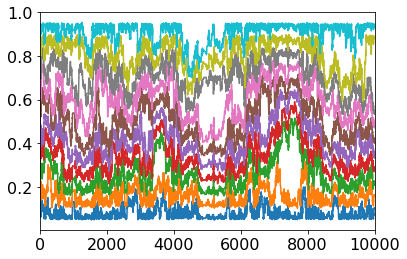

In [458]:
plt.plot(traj_rep1d[:, 0])
plt.plot(traj_rep1d[:, 1])
plt.plot(traj_rep1d[:, 2])
plt.plot(traj_rep1d[:, 3])
plt.plot(traj_rep1d[:, 4])
plt.plot(traj_rep1d[:, 5])
plt.plot(traj_rep1d[:, 6])
plt.plot(traj_rep1d[:, 7])
plt.plot(traj_rep1d[:, 8])
plt.plot(traj_rep1d[:, 9])
plt.xlim(0, 10000)

(0, 0.5)

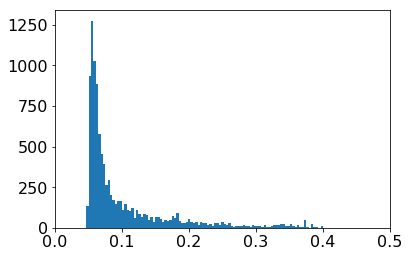

In [523]:
d12 = np.abs(traj_rep1d[:, 2] - traj_rep1d[:, 1])
d12 = np.minimum(d12, 1.0-d12)
plt.hist(d12, 100);
plt.xlim(0, 0.5)

(0, 0.5)

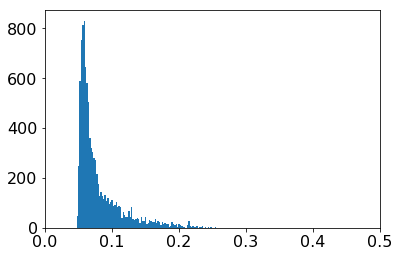

In [524]:
d12 = np.abs(traj_rep1d[:, 1] - traj_rep1d[:, 0])
d12 = np.minimum(d12, 1.0-d12)
plt.hist(d12, 100);
plt.xlim(0, 0.5)

(0, 0.5)

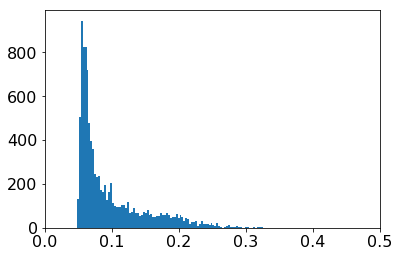

In [530]:
d12 = np.abs(traj_rep1d[:, 6] - traj_rep1d[:, 5])
d12 = np.minimum(d12, 1.0-d12)
plt.hist(d12, 100);
plt.xlim(0, 0.5)

Conditional Sampler in the 1D system
----

In [460]:
# permute coordinates for conditional Boltzmann Generator
def permute(x, samplefirst, samplelast):
    batchsize = x.shape[0]
    xperm = []
    for t in range(batchsize):
        Irest = np.array(list(set(list(np.arange(x.shape[1]))) - 
                              set(list(np.arange(samplefirst[t]-1, samplelast[t]+2)))))
        Irest.sort()
        I = np.concatenate([np.arange(samplefirst[t], samplelast[t]+1), [samplefirst[t]-1], [samplelast[t]+1], Irest])
        xperm.append(x[t, I])
    return np.array(xperm)

def permuteback(x, samplefirst, samplelast):
    batchsize = x.shape[0]
    xpermback = []
    for t in range(batchsize):
        S = permute(np.array([np.arange(x.shape[1])]), [samplefirst[t]], [samplelast[t]])[0]
        I = np.argsort(S)
        xpermback.append(x[t, I])
    return np.array(xpermback)

In [461]:
samplefirst = np.random.randint(1, 7, size=traj_rep1d.shape[0])
samplelast = samplefirst + 2
xperm = permute(traj_rep1d, samplefirst, samplelast)
xpermback = permuteback(xperm, samplefirst, samplelast)

(0, 50)

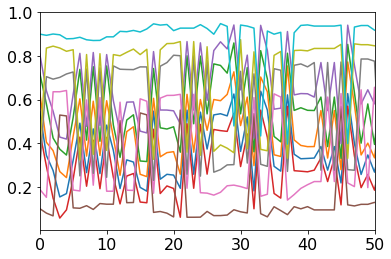

In [462]:
plt.plot(xperm[:, 0])
plt.plot(xperm[:, 1])
plt.plot(xperm[:, 2])
plt.plot(xperm[:, 3])
plt.plot(xperm[:, 4])
plt.plot(xperm[:, 5])
plt.plot(xperm[:, 6])
plt.plot(xperm[:, 7])
plt.plot(xperm[:, 8])
plt.plot(xperm[:, 9])
plt.xlim(0, 50)

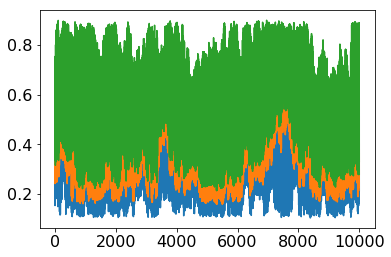

In [500]:
plt.plot(xperm[:, 0])
plt.plot(xperm[:, 1])
plt.plot(xperm[:, 2])
#plt.xlim(7000, 7500)

(0, 10000)

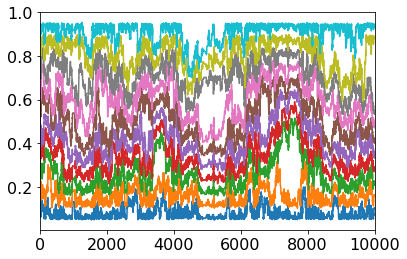

In [463]:
plt.plot(xpermback[:, 0])
plt.plot(xpermback[:, 1])
plt.plot(xpermback[:, 2])
plt.plot(xpermback[:, 3])
plt.plot(xpermback[:, 4])
plt.plot(xpermback[:, 5])
plt.plot(xpermback[:, 6])
plt.plot(xpermback[:, 7])
plt.plot(xpermback[:, 8])
plt.plot(xpermback[:, 9])
plt.xlim(0, 10000)

In [464]:
x_train = xperm[::2]
x_val = xperm[1::2]

In [620]:
network2 = invnet(10, 3, 'RRRR', energy_model=rep1d, 
                  nl_layers=4, nl_hidden=200, nl_activation='tanh', 
                  condition=(3, 2))

<RRRR>


In [621]:
losses_ML1 = network2.train_ML(x_train, xval=x_val, lr=0.001, epochs=100)

Train on 5001 samples, validate on 5000 samples
Epoch 1/100
5001/5001 [==============================] - 15s 3ms/step - loss: 0.4968 - val_loss: -0.8163
Epoch 2/100
5001/5001 [==============================] - 1s 152us/step - loss: -1.5887 - val_loss: -2.8810
Epoch 3/100
5001/5001 [==============================] - 1s 154us/step - loss: -3.4682 - val_loss: -4.0739
Epoch 4/100
5001/5001 [==============================] - 1s 154us/step - loss: -3.1583 - val_loss: -1.2875
Epoch 5/100
5001/5001 [==============================] - 1s 159us/step - loss: -3.9690 - val_loss: -4.3181
Epoch 6/100
5001/5001 [==============================] - 1s 156us/step - loss: -4.2575 - val_loss: -4.6594
Epoch 7/100
5001/5001 [==============================] - 1s 156us/step - loss: -4.9007 - val_loss: -5.3890
Epoch 8/100
5001/5001 [==============================] - 1s 159us/step - loss: -4.4810 - val_loss: -3.1953
Epoch 9/100
5001/5001 [==============================] - 1s 162us/step - loss: -4.3318 - val_loss:

5001/5001 [==============================] - 1s 170us/step - loss: -3.1174 - val_loss: -2.9690
Epoch 77/100
5001/5001 [==============================] - 1s 168us/step - loss: -3.4024 - val_loss: -4.0381
Epoch 78/100
5001/5001 [==============================] - 1s 169us/step - loss: -4.8226 - val_loss: -5.1381
Epoch 79/100
5001/5001 [==============================] - 1s 170us/step - loss: -5.0493 - val_loss: -6.0395
Epoch 80/100
5001/5001 [==============================] - 1s 170us/step - loss: -2.5379 - val_loss: -2.0487
Epoch 81/100
5001/5001 [==============================] - 1s 170us/step - loss: -3.6117 - val_loss: -5.2868
Epoch 82/100
5001/5001 [==============================] - 1s 169us/step - loss: -5.1523 - val_loss: -5.2863
Epoch 83/100
5001/5001 [==============================] - 1s 171us/step - loss: -5.3838 - val_loss: -5.8288
Epoch 84/100
5001/5001 [==============================] - 1s 171us/step - loss: -6.1125 - val_loss: -6.4515
Epoch 85/100
5001/5001 [=================

In [622]:
losses_ML2 = network2.train_ML(x_train, xval=x_val, lr=0.0001, epochs=1000)

Train on 5001 samples, validate on 5000 samples
Epoch 1/1000
5001/5001 [==============================] - 15s 3ms/step - loss: -5.8279 - val_loss: -7.3725
Epoch 2/1000
5001/5001 [==============================] - 1s 161us/step - loss: -7.7089 - val_loss: -8.2712
Epoch 3/1000
5001/5001 [==============================] - 1s 161us/step - loss: -8.0934 - val_loss: -7.8787
Epoch 4/1000
5001/5001 [==============================] - 1s 162us/step - loss: -8.1271 - val_loss: -8.2434
Epoch 5/1000
5001/5001 [==============================] - 1s 164us/step - loss: -8.3136 - val_loss: -8.3435
Epoch 6/1000
5001/5001 [==============================] - 1s 165us/step - loss: -8.3311 - val_loss: -8.4219
Epoch 7/1000
5001/5001 [==============================] - 1s 164us/step - loss: -8.4675 - val_loss: -8.4902
Epoch 8/1000
5001/5001 [==============================] - 1s 165us/step - loss: -8.5093 - val_loss: -8.5384
Epoch 9/1000
5001/5001 [==============================] - 1s 170us/step - loss: -8.5733 -

Epoch 76/1000
5001/5001 [==============================] - 1s 181us/step - loss: -9.3445 - val_loss: -9.3773
Epoch 77/1000
5001/5001 [==============================] - 1s 179us/step - loss: -9.2610 - val_loss: -9.2178
Epoch 78/1000
5001/5001 [==============================] - 1s 172us/step - loss: -9.2659 - val_loss: -9.2331
Epoch 79/1000
5001/5001 [==============================] - 1s 171us/step - loss: -9.2958 - val_loss: -9.2810
Epoch 80/1000
5001/5001 [==============================] - 1s 173us/step - loss: -9.2969 - val_loss: -9.3495
Epoch 81/1000
5001/5001 [==============================] - 1s 172us/step - loss: -9.2902 - val_loss: -9.3147
Epoch 82/1000
5001/5001 [==============================] - 1s 173us/step - loss: -9.3577 - val_loss: -9.3301
Epoch 83/1000
5001/5001 [==============================] - 1s 168us/step - loss: -9.3601 - val_loss: -9.4133
Epoch 84/1000
5001/5001 [==============================] - 1s 170us/step - loss: -9.3961 - val_loss: -9.3462
Epoch 85/1000
5001/

5001/5001 [==============================] - 1s 173us/step - loss: -9.7065 - val_loss: -9.7083
Epoch 151/1000
5001/5001 [==============================] - 1s 171us/step - loss: -9.7236 - val_loss: -9.7127
Epoch 152/1000
5001/5001 [==============================] - 1s 171us/step - loss: -9.7140 - val_loss: -9.6904
Epoch 153/1000
5001/5001 [==============================] - 1s 170us/step - loss: -9.7178 - val_loss: -9.6804
Epoch 154/1000
5001/5001 [==============================] - 1s 171us/step - loss: -9.6780 - val_loss: -9.6141
Epoch 155/1000
5001/5001 [==============================] - 1s 175us/step - loss: -9.6358 - val_loss: -9.6389
Epoch 156/1000
5001/5001 [==============================] - 1s 178us/step - loss: -9.6956 - val_loss: -9.7385
Epoch 157/1000
5001/5001 [==============================] - 1s 177us/step - loss: -9.7233 - val_loss: -9.7310
Epoch 158/1000
5001/5001 [==============================] - 1s 173us/step - loss: -9.7410 - val_loss: -9.7407
Epoch 159/1000
5001/5001 

5001/5001 [==============================] - 1s 180us/step - loss: -9.9204 - val_loss: -9.9161
Epoch 225/1000
5001/5001 [==============================] - 1s 177us/step - loss: -9.9129 - val_loss: -9.8688
Epoch 226/1000
5001/5001 [==============================] - 1s 173us/step - loss: -9.8760 - val_loss: -9.9270
Epoch 227/1000
5001/5001 [==============================] - 1s 174us/step - loss: -9.8841 - val_loss: -9.8057
Epoch 228/1000
5001/5001 [==============================] - 1s 173us/step - loss: -9.8635 - val_loss: -9.9133
Epoch 229/1000
5001/5001 [==============================] - 1s 174us/step - loss: -9.9117 - val_loss: -9.9350
Epoch 230/1000
5001/5001 [==============================] - 1s 174us/step - loss: -9.9341 - val_loss: -9.9096
Epoch 231/1000
5001/5001 [==============================] - 1s 172us/step - loss: -9.9116 - val_loss: -9.9169
Epoch 232/1000
5001/5001 [==============================] - 1s 169us/step - loss: -9.9295 - val_loss: -9.9079
Epoch 233/1000
5001/5001 

5001/5001 [==============================] - 1s 179us/step - loss: -10.0758 - val_loss: -10.0725
Epoch 299/1000
5001/5001 [==============================] - 1s 178us/step - loss: -10.0873 - val_loss: -10.0817
Epoch 300/1000
5001/5001 [==============================] - 1s 175us/step - loss: -10.0776 - val_loss: -9.9590
Epoch 301/1000
5001/5001 [==============================] - 1s 170us/step - loss: -9.8940 - val_loss: -9.1790
Epoch 302/1000
5001/5001 [==============================] - 1s 173us/step - loss: -9.3878 - val_loss: -9.4925
Epoch 303/1000
5001/5001 [==============================] - 1s 173us/step - loss: -9.6853 - val_loss: -9.7019
Epoch 304/1000
5001/5001 [==============================] - 1s 173us/step - loss: -9.8619 - val_loss: -9.9717
Epoch 305/1000
5001/5001 [==============================] - 1s 171us/step - loss: -9.9636 - val_loss: -10.0273
Epoch 306/1000
5001/5001 [==============================] - 1s 171us/step - loss: -10.0299 - val_loss: -10.0405
Epoch 307/1000
50

5001/5001 [==============================] - 1s 177us/step - loss: -10.1429 - val_loss: -10.1425
Epoch 372/1000
5001/5001 [==============================] - 1s 175us/step - loss: -10.1575 - val_loss: -10.1494
Epoch 373/1000
5001/5001 [==============================] - 1s 173us/step - loss: -10.1676 - val_loss: -10.1642
Epoch 374/1000
5001/5001 [==============================] - 1s 174us/step - loss: -10.1773 - val_loss: -10.1672
Epoch 375/1000
5001/5001 [==============================] - 1s 174us/step - loss: -10.1884 - val_loss: -10.1718
Epoch 376/1000
5001/5001 [==============================] - 1s 178us/step - loss: -10.1954 - val_loss: -10.1861
Epoch 377/1000
5001/5001 [==============================] - 1s 179us/step - loss: -10.1847 - val_loss: -10.1827
Epoch 378/1000
5001/5001 [==============================] - 1s 175us/step - loss: -10.1690 - val_loss: -10.1675
Epoch 379/1000
5001/5001 [==============================] - 1s 174us/step - loss: -10.1594 - val_loss: -10.1112
Epoch 3

5001/5001 [==============================] - 1s 170us/step - loss: -10.2523 - val_loss: -10.2264
Epoch 445/1000
5001/5001 [==============================] - 1s 170us/step - loss: -10.2575 - val_loss: -10.2274
Epoch 446/1000
5001/5001 [==============================] - 1s 172us/step - loss: -10.2466 - val_loss: -10.2002
Epoch 447/1000
5001/5001 [==============================] - 1s 178us/step - loss: -10.2405 - val_loss: -10.1568
Epoch 448/1000
5001/5001 [==============================] - 1s 176us/step - loss: -10.1490 - val_loss: -10.1302
Epoch 449/1000
5001/5001 [==============================] - 1s 177us/step - loss: -10.1522 - val_loss: -10.2198
Epoch 450/1000
5001/5001 [==============================] - 1s 176us/step - loss: -10.0971 - val_loss: -10.0672
Epoch 451/1000
5001/5001 [==============================] - 1s 173us/step - loss: -10.1217 - val_loss: -10.1013
Epoch 452/1000
5001/5001 [==============================] - 1s 174us/step - loss: -10.1508 - val_loss: -10.1227
Epoch 4

5001/5001 [==============================] - 1s 181us/step - loss: -10.2901 - val_loss: -10.1581
Epoch 518/1000
5001/5001 [==============================] - 1s 176us/step - loss: -10.2084 - val_loss: -10.2209
Epoch 519/1000
5001/5001 [==============================] - 1s 174us/step - loss: -10.2409 - val_loss: -10.1898
Epoch 520/1000
5001/5001 [==============================] - 1s 172us/step - loss: -10.1399 - val_loss: -9.8392
Epoch 521/1000
5001/5001 [==============================] - 1s 173us/step - loss: -9.9871 - val_loss: -10.1179
Epoch 522/1000
5001/5001 [==============================] - 1s 173us/step - loss: -10.1383 - val_loss: -10.1006
Epoch 523/1000
5001/5001 [==============================] - 1s 173us/step - loss: -10.1827 - val_loss: -10.1278
Epoch 524/1000
5001/5001 [==============================] - 1s 171us/step - loss: -10.1976 - val_loss: -10.1163
Epoch 525/1000
5001/5001 [==============================] - 1s 173us/step - loss: -10.2127 - val_loss: -10.1620
Epoch 526

5001/5001 [==============================] - 1s 170us/step - loss: -10.3110 - val_loss: -10.2946
Epoch 591/1000
5001/5001 [==============================] - 1s 170us/step - loss: -10.3221 - val_loss: -10.3028
Epoch 592/1000
5001/5001 [==============================] - 1s 172us/step - loss: -10.3380 - val_loss: -10.3016
Epoch 593/1000
5001/5001 [==============================] - 1s 171us/step - loss: -10.3393 - val_loss: -10.2622
Epoch 594/1000
5001/5001 [==============================] - 1s 174us/step - loss: -10.3157 - val_loss: -10.2761
Epoch 595/1000
5001/5001 [==============================] - 1s 174us/step - loss: -10.3291 - val_loss: -10.2916
Epoch 596/1000
5001/5001 [==============================] - 1s 179us/step - loss: -10.3220 - val_loss: -10.2901
Epoch 597/1000
5001/5001 [==============================] - 1s 175us/step - loss: -10.3255 - val_loss: -10.2879
Epoch 598/1000
5001/5001 [==============================] - 1s 171us/step - loss: -10.3249 - val_loss: -10.2911
Epoch 5

5001/5001 [==============================] - 1s 174us/step - loss: -9.2921 - val_loss: -9.2794
Epoch 665/1000
5001/5001 [==============================] - 1s 176us/step - loss: -9.3082 - val_loss: -9.2863
Epoch 666/1000
5001/5001 [==============================] - 1s 176us/step - loss: -9.3130 - val_loss: -9.2826
Epoch 667/1000
5001/5001 [==============================] - 1s 179us/step - loss: -9.3260 - val_loss: -9.2938
Epoch 668/1000
5001/5001 [==============================] - 1s 171us/step - loss: -9.3265 - val_loss: -9.3203
Epoch 669/1000
5001/5001 [==============================] - 1s 172us/step - loss: -9.3343 - val_loss: -9.3077
Epoch 670/1000
5001/5001 [==============================] - 1s 174us/step - loss: -9.3499 - val_loss: -9.3339
Epoch 671/1000
5001/5001 [==============================] - 1s 172us/step - loss: -9.3678 - val_loss: -9.3390
Epoch 672/1000
5001/5001 [==============================] - 1s 174us/step - loss: -9.3776 - val_loss: -9.3551
Epoch 673/1000
5001/5001 

5001/5001 [==============================] - 1s 175us/step - loss: -9.8450 - val_loss: -9.8205
Epoch 739/1000
5001/5001 [==============================] - 1s 171us/step - loss: -9.8541 - val_loss: -9.8269
Epoch 740/1000
5001/5001 [==============================] - 1s 169us/step - loss: -9.8576 - val_loss: -9.8279
Epoch 741/1000
5001/5001 [==============================] - 1s 172us/step - loss: -9.8631 - val_loss: -9.8344
Epoch 742/1000
5001/5001 [==============================] - 1s 172us/step - loss: -9.8695 - val_loss: -9.8403
Epoch 743/1000
5001/5001 [==============================] - 1s 172us/step - loss: -9.8704 - val_loss: -9.8345
Epoch 744/1000
5001/5001 [==============================] - 1s 173us/step - loss: -9.8766 - val_loss: -9.8469
Epoch 745/1000
5001/5001 [==============================] - 1s 170us/step - loss: -9.8819 - val_loss: -9.8469
Epoch 746/1000
5001/5001 [==============================] - 1s 168us/step - loss: -9.8723 - val_loss: -9.8493
Epoch 747/1000
5001/5001 

5001/5001 [==============================] - 1s 170us/step - loss: -10.1133 - val_loss: -10.0785
Epoch 813/1000
5001/5001 [==============================] - 1s 171us/step - loss: -10.1121 - val_loss: -10.0462
Epoch 814/1000
5001/5001 [==============================] - 1s 176us/step - loss: -10.0948 - val_loss: -10.0468
Epoch 815/1000
5001/5001 [==============================] - 1s 177us/step - loss: -10.0855 - val_loss: -10.0749
Epoch 816/1000
5001/5001 [==============================] - 1s 178us/step - loss: -10.0763 - val_loss: -10.0144
Epoch 817/1000
5001/5001 [==============================] - 1s 173us/step - loss: -10.0730 - val_loss: -10.0867
Epoch 818/1000
5001/5001 [==============================] - 1s 173us/step - loss: -10.0866 - val_loss: -10.0541
Epoch 819/1000
5001/5001 [==============================] - 1s 172us/step - loss: -10.0601 - val_loss: -9.9504
Epoch 820/1000
5001/5001 [==============================] - 1s 172us/step - loss: -10.0549 - val_loss: -10.0565
Epoch 82

5001/5001 [==============================] - 1s 174us/step - loss: -10.2272 - val_loss: -10.2086
Epoch 886/1000
5001/5001 [==============================] - 1s 173us/step - loss: -10.2447 - val_loss: -10.2135
Epoch 887/1000
5001/5001 [==============================] - 1s 171us/step - loss: -10.2463 - val_loss: -10.1875
Epoch 888/1000
5001/5001 [==============================] - 1s 174us/step - loss: -10.2361 - val_loss: -10.1945
Epoch 889/1000
5001/5001 [==============================] - 1s 172us/step - loss: -10.2413 - val_loss: -10.2093
Epoch 890/1000
5001/5001 [==============================] - 1s 171us/step - loss: -10.2363 - val_loss: -10.2095
Epoch 891/1000
5001/5001 [==============================] - 1s 165us/step - loss: -10.2363 - val_loss: -10.1990
Epoch 892/1000
5001/5001 [==============================] - 1s 170us/step - loss: -10.2040 - val_loss: -10.1494
Epoch 893/1000
5001/5001 [==============================] - 1s 173us/step - loss: -10.2199 - val_loss: -10.1697
Epoch 8

5001/5001 [==============================] - 1s 170us/step - loss: -10.2695 - val_loss: -10.2316
Epoch 959/1000
5001/5001 [==============================] - 1s 171us/step - loss: -10.2881 - val_loss: -10.2266
Epoch 960/1000
5001/5001 [==============================] - 1s 174us/step - loss: -10.2987 - val_loss: -10.2882
Epoch 961/1000
5001/5001 [==============================] - 1s 171us/step - loss: -10.3176 - val_loss: -10.2711
Epoch 962/1000
5001/5001 [==============================] - 1s 172us/step - loss: -10.3217 - val_loss: -10.2850
Epoch 963/1000
5001/5001 [==============================] - 1s 176us/step - loss: -10.3270 - val_loss: -10.2846
Epoch 964/1000
5001/5001 [==============================] - 1s 221us/step - loss: -10.3161 - val_loss: -10.2792
Epoch 965/1000
5001/5001 [==============================] - 1s 214us/step - loss: -10.3261 - val_loss: -10.2945
Epoch 966/1000
5001/5001 [==============================] - 1s 213us/step - loss: -10.3177 - val_loss: -10.2812
Epoch 9

(-10.8, -10)

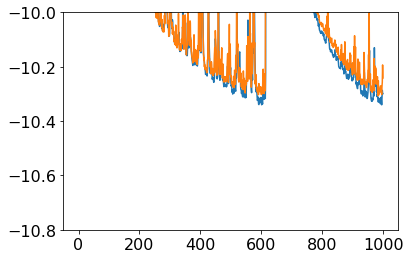

In [623]:
plt.plot(losses_ML2.history['loss'])
plt.plot(losses_ML2.history['val_loss'])
plt.ylim(-10.8, -10)

In [619]:
losses_KL1 = network2.train_flexible(x_train, xval=x_val, epochs=200, batch_size=2048, lr=0.000001, high_energy=100000)

Epoch 0/200 loss 445.2083 392.6989 output_z_loss -10.5215 -10.5428 concatenate_451_loss 455.7297 403.2418 
Epoch 1/200 loss 109.1717 238.2818 output_z_loss -10.5532 -10.4207 concatenate_451_loss 119.7249 248.7026 
Epoch 2/200 loss 357.5455 223.9686 output_z_loss -10.6309 -10.4177 concatenate_451_loss 368.1764 234.3864 
Epoch 3/200 loss 401.9704 420.5754 output_z_loss -10.6612 -10.4569 concatenate_451_loss 412.6316 431.0323 
Epoch 4/200 loss 379.4860 351.4030 output_z_loss -10.6114 -10.5491 concatenate_451_loss 390.0974 361.9521 
Epoch 5/200 loss 236.9393 43.6986 output_z_loss -10.6070 -10.5743 concatenate_451_loss 247.5463 54.2729 
Epoch 6/200 loss 191.7845 462.2183 output_z_loss -10.6209 -10.4939 concatenate_451_loss 202.4054 472.7122 
Epoch 7/200 loss 63.6081 345.4296 output_z_loss -10.5627 -10.6242 concatenate_451_loss 74.1709 356.0537 
Epoch 8/200 loss 452.5019 340.8986 output_z_loss -10.6661 -10.5048 concatenate_451_loss 463.1680 351.4034 
Epoch 9/200 loss 480.3576 161.3435 output

Epoch 77/200 loss 138.3227 253.8563 output_z_loss -10.2027 -10.0141 concatenate_451_loss 148.5253 263.8704 
Epoch 78/200 loss 258.5535 296.4303 output_z_loss -10.1918 -9.9823 concatenate_451_loss 268.7453 306.4126 
Epoch 79/200 loss 207.5502 224.0809 output_z_loss -10.2150 -10.1136 concatenate_451_loss 217.7653 234.1945 
Epoch 80/200 loss 334.6808 405.8327 output_z_loss -10.1191 -10.1266 concatenate_451_loss 344.7998 415.9593 
Epoch 81/200 loss 334.6694 155.7994 output_z_loss -10.1845 -10.0303 concatenate_451_loss 344.8539 165.8297 
Epoch 82/200 loss 333.4750 196.1918 output_z_loss -10.1366 -9.8515 concatenate_451_loss 343.6117 206.0432 
Epoch 83/200 loss 44.4438 254.5289 output_z_loss -10.1220 -10.1036 concatenate_451_loss 54.5658 264.6326 
Epoch 84/200 loss 311.6033 255.6310 output_z_loss -10.1597 -10.1291 concatenate_451_loss 321.7630 265.7601 
Epoch 85/200 loss 221.2561 92.3678 output_z_loss -10.0609 -10.0528 concatenate_451_loss 231.3170 102.4206 
Epoch 86/200 loss 134.2875 248.12

KeyboardInterrupt: 

In [607]:
losses_KL2 = network2.train_flexible(x_train, xval=x_val, epochs=100, batch_size=2048, lr=0.000001, high_energy=10000)

Epoch 0/100 loss 44.7838 63.1221 output_z_loss -10.4547 -10.2673 concatenate_432_loss 55.2385 73.3894 
Epoch 1/100 loss 24.1044 51.1023 output_z_loss -10.3717 -10.2004 concatenate_432_loss 34.4761 61.3027 
Epoch 2/100 loss 39.5225 44.2342 output_z_loss -10.2788 -10.1119 concatenate_432_loss 49.8014 54.3461 
Epoch 3/100 loss 22.2601 41.1075 output_z_loss -10.1827 -10.2337 concatenate_432_loss 32.4428 51.3413 
Epoch 4/100 loss 22.6028 51.2802 output_z_loss -10.2288 -10.1616 concatenate_432_loss 32.8315 61.4418 
Epoch 5/100 loss 60.3740 43.7516 output_z_loss -10.2229 -10.2395 concatenate_432_loss 70.5969 53.9912 
Epoch 6/100 loss 3.1009 70.7537 output_z_loss -10.2564 -10.2249 concatenate_432_loss 13.3573 80.9786 
Epoch 7/100 loss 47.5829 nan output_z_loss -10.2570 nan concatenate_432_loss 57.8399 nan 
Epoch 8/100 loss nan nan output_z_loss nan nan concatenate_432_loss nan nan 
Epoch 9/100 loss nan nan output_z_loss nan nan concatenate_432_loss nan nan 
Epoch 10/100 loss nan nan output_z_l

KeyboardInterrupt: 

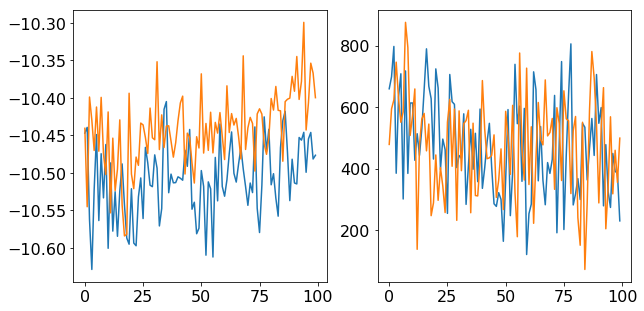

In [606]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(losses_KL1[1][:, 1])
axes[0].plot(losses_KL1[2][:, 1])
axes[1].plot(losses_KL1[1][:, 2])
axes[1].plot(losses_KL1[2][:, 2])

Independent sampling
--

In [624]:
#xcond = np.tile(x_train[0], 10000).reshape((10000, 10))
xcond = x_train
nsample = xcond.shape[0]

In [625]:
_, xsample, _, _, _ = network2.sample(nsample=nsample, x=xcond)

(0, 1)

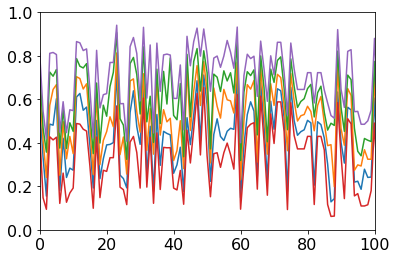

In [626]:
plt.plot(xsample[:, 0])
plt.plot(xsample[:, 1])
plt.plot(xsample[:, 2])
plt.plot(xsample[:, 3])
plt.plot(xsample[:, 4])
plt.xlim(0, 100)
plt.ylim(0, 1)

(0, 1)

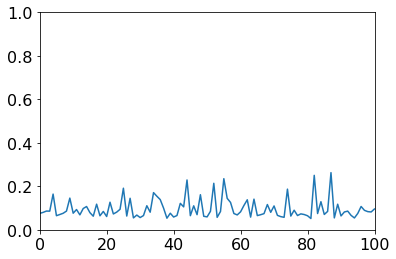

In [627]:
plt.plot(xsample[:, 1]-xsample[:, 0])
plt.xlim(0, 100)
plt.ylim(0, 1)

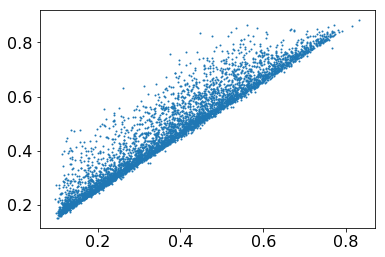

In [628]:
plt.plot(xsample[:, 0], xsample[:, 1], linewidth=0, marker='.', markersize=2)

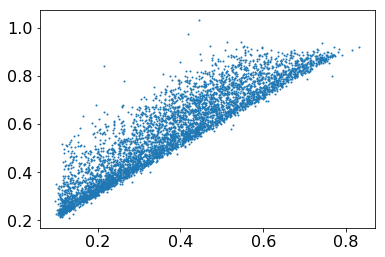

In [629]:
plt.plot(xsample[:, 0], xsample[:, 2], linewidth=0, marker='.', markersize=2)

(0, 0.5)

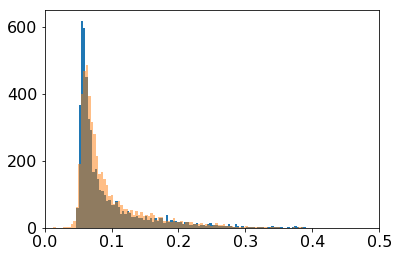

In [630]:
d12t = np.abs(x_train[:, 1] - x_train[:, 0])
d12 = np.abs(xsample[:, 1] - xsample[:, 0])
d12 = np.minimum(d12, 1.0-d12)
plt.hist(d12t, 100);
plt.hist(d12, 100, alpha=0.5);
plt.xlim(0, 0.5)
#plt.semilogy()

Gibbs sampling
------

In [653]:
Nsample = 10000
std_z = 1.0
temperature = 1.0

In [655]:
x_gibbs = [traj_rep1d[0].copy()]
e_gibbs = [rep1d.energy(x_gibbs)[0] / temperature]

for t in range(Nsample):
    if t%100 == 0:
        print(t)
    # sample block of variables to be Boltzmann-sampled
    samplefirst = np.random.randint(1, 7, size=1)
    samplelast = samplefirst + 2
    # permute to prepare for sampling
    x_cur = permute(np.array([x_gibbs[-1]]), samplefirst, samplelast)
    # compute z-value for this input
    z_cur, Jxz_cur = network2.transform_xzJ(x_cur)
    #print('zcur', (np.sum(z_cur**2)))
    # sample
    z_propose, x_sample, _, _, _ = network2.sample(nsample=1, x=x_cur)
    _, Jxz_propose = network2.transform_xzJ(x_sample)
    # permute back: this is the proposal
    x_propose = permuteback(x_sample, samplefirst, samplelast)
    e_propose = rep1d.energy(x_propose)[0] / temperature
    # accept or reject
    factor = 1.0 / (2.0 * std_z * std_z)
    log_p_forward = -factor * np.sum(z_propose**2)
    log_p_backward = -factor * np.sum(z_cur**2)
    #print('Jxz cur', Jxz_cur, 'prop', Jxz_propose, 'diff', (-Jxz_cur + Jxz_propose))
    #print('E curr', e_gibbs[-1], 'E prop', e_propose, 'diff', (e_propose - e_gibbs[-1]))
    #print('log p forw', log_p_forward, 'back', log_p_backward, 'diff', (log_p_forward - log_p_backward))
    #print()
    R = -np.log(np.random.rand())
    if R > -Jxz_cur + Jxz_propose + e_propose - e_gibbs[-1] + log_p_forward - log_p_backward:
        x_gibbs.append(x_propose[0])
        e_gibbs.append(e_propose)
    else:
        x_gibbs.append(x_gibbs[-1].copy())
        e_gibbs.append(e_gibbs[-1])

x_gibbs = np.array(x_gibbs)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


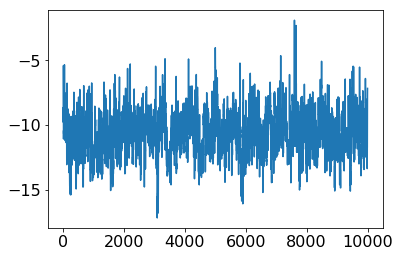

In [656]:
plt.plot(e_gibbs)
#plt.semilogy()

(0, 1000)

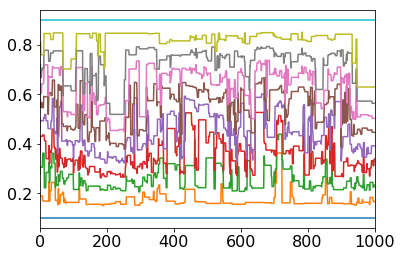

In [659]:
for i in range(10):
    plt.plot(x_gibbs[:, i])
plt.xlim(0, 1000)

(0, 0.5)

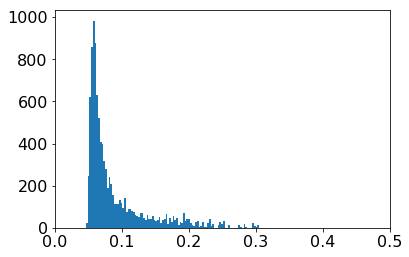

In [665]:
d12 = np.abs(x_gibbs[:, 5] - x_gibbs[:, 4])
d12 = np.minimum(d12, 1.0-d12)
plt.hist(d12, 100);
plt.xlim(0, 0.5)